**This notebook contains the data exploration for the final project of the MLOps-Zoomcamp.** 

# Energy Efficiency

<figure>
    <img src="Energy_gains_and_losses_through_building.jpg" alt="heat load sketch" width="400"/>
    <figcaption align="center">Source: https://en.wikipedia.org/wiki/File:Energy_gains_and_losses_through_building.jpg</figcaption>
</figure>

## Objective: Predict the Heating Load

Analyzing the energy efficiency of buildings gains more and more importancy considering climate change and rising energy costs. In this project I will analyse and predict the heat load of a building given different building characteristics.

Given is a tabular dataset, with 8 different building features, which will be used to predict the Heating Load of the building. The term *Heat load* refers to the amount of heating that a building needs in order to maintain the indoor temperature at established levels.

The dataset can be downloaded from [kaggle](https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset). The features are denoted with ```X1``` to ```X8``` and the target variable is denoted as ```y1```.

**Note:** The Dataset contains another predictable variable: ```y2```, the "Cooling Load", which can also be predicted from the given features. The cooling load is the amount of heat energy that would need to be removed from a space (cooling) to maintain the temperature in an acceptable range. However, in this project I will focus on only one model predicting the "Heating Load".

More specifically the features are the following:
* X1 Relative Compactnes 
    * This is the volume to surface ratio. Buildings with a lower compactness have a larger surface area for a given volume.
* X2 Surface Area ($m^2$)
* X3 Wall Area ($m^2$)
* X4 Roof Area ($m^2$)
* X5 Overall Height ($m$)
* X6 Orientation (2: North, 3: East, 4: South, 5: West)
* X7 Glazing Area (0%, 10%, 25%, 40% (of floor area))
    * This is the area of transparent material, not including the window frame.
* X8 Glazing Area Distribution ((Variance) - 1: Uniform, 2: North, 3: East, 4: South, 5: West)
* Y1 Heating Load ($kWh/m²$)
* (Y2 Cooling Load ($kWh/m²$))

## Setup

The next cell contains all packages needed to run this notebook

In [1]:
import os
import pandas as pd
import numpy as np
import math

# modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

Read the data from a csv file.

In [2]:
path = "data"
data = pd.read_csv(os.path.join(path, "ENB2012_data.csv"))

## Data Overview

Get a first overview about the data:
* How many instances does the dataset contain?
* Are there missing values?
* What are the datatypes?
* What is the range of the feature values?

In [3]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
data.tail()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
763,0.64,784.0,343.0,220.5,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.5,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.5,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.5,3.5,4,0.4,5,16.48,16.61
767,0.62,808.5,367.5,220.5,3.5,5,0.4,5,16.64,16.03


Rename the columns for a better overview about th features.

In [5]:
data = data.rename(columns={"X1": "relative_compactnes", "X2": "surface_area",
                     "X3": "wall_area", "X4": "roof_area", "X5": "overall_height",
                     "X6": "orientation", "X7": "glazing_area", "X8": "glazing_area_distribution",
                     "Y1": "heating_load", "Y2": "cooling_load"})

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactnes        768 non-null    float64
 1   surface_area               768 non-null    float64
 2   wall_area                  768 non-null    float64
 3   roof_area                  768 non-null    float64
 4   overall_height             768 non-null    float64
 5   orientation                768 non-null    int64  
 6   glazing_area               768 non-null    float64
 7   glazing_area_distribution  768 non-null    int64  
 8   heating_load               768 non-null    float64
 9   cooling_load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [7]:
# how many unique values contains each column
data.nunique()

relative_compactnes           12
surface_area                  12
wall_area                      7
roof_area                      4
overall_height                 2
orientation                    4
glazing_area                   4
glazing_area_distribution      6
heating_load                 586
cooling_load                 636
dtype: int64

In [8]:
# general statistic information about all columns in the dataframe
data.describe()

,relative_compactnes,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


**Observations:**
* The dataset contains 768 instances.
* There is no missing data.
* Data types are integer and float. The features "orientation" and "glazing_area_distribution" are categorical features and should be turned in type ```string```, so that we can later use this for one-hot encoding.
* The features are in different ranges and should be normalized before modelling.

In [9]:
# change data type from integer to string for categorical features
data[["orientation", "glazing_area_distribution"]] = data[["orientation", "glazing_area_distribution"]].astype("string")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactnes        768 non-null    float64
 1   surface_area               768 non-null    float64
 2   wall_area                  768 non-null    float64
 3   roof_area                  768 non-null    float64
 4   overall_height             768 non-null    float64
 5   orientation                768 non-null    string 
 6   glazing_area               768 non-null    float64
 7   glazing_area_distribution  768 non-null    string 
 8   heating_load               768 non-null    float64
 9   cooling_load               768 non-null    float64
dtypes: float64(8), string(2)
memory usage: 60.1 KB


## Plot Distributions of Features and Target
To get a further overview about the data, we have a look at the distributions of the single columns.

In [10]:
# credits to: https://github.com/dformoso/sklearn-classification/blob/master/Data%20Science%20Workbook%20-%20Census%20Income%20Dataset.ipynb
# Define a function to plot the distribution of each feature
def plot_distribution(dataset, cols=3, width=20, height=25, hspace=0.5, wspace=0.2):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == "string":
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xlim([0, 200])
            plt.xticks(rotation=25)
        else:
            g = sns.histplot(dataset[column])
            plt.xticks(rotation=25)

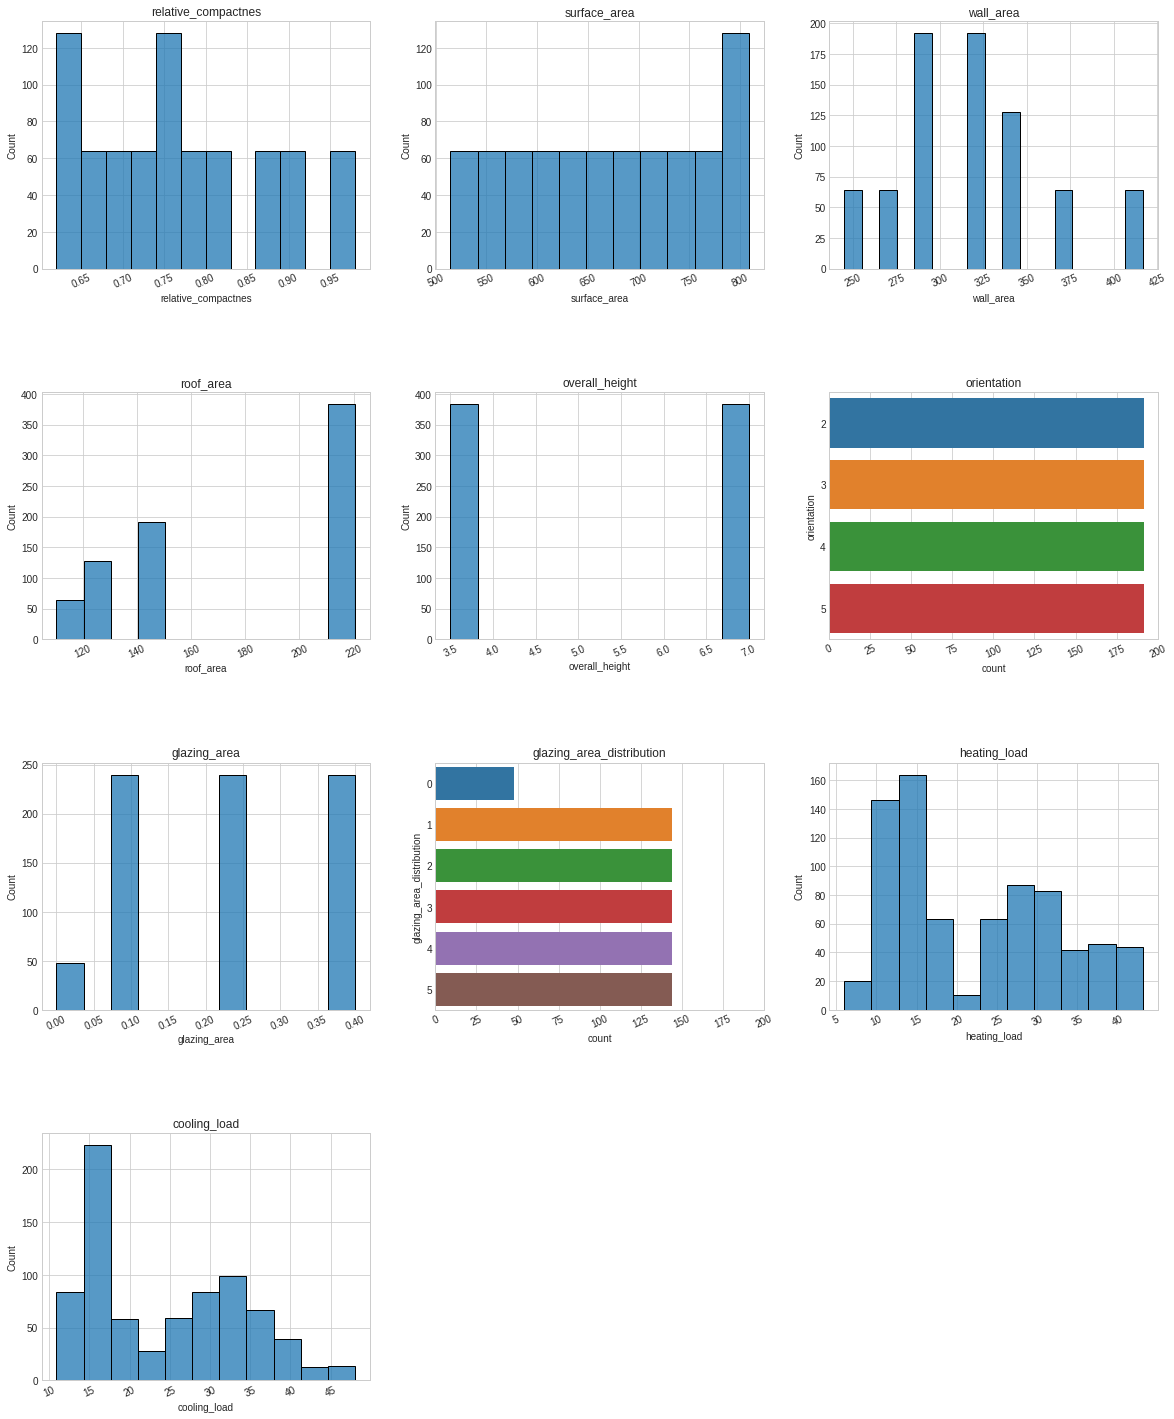

In [11]:
plot_distribution(data)

**Observations**
* The target variable "heating_load" is not normally distributed. (The second variable "cooling_load" is also not normally distributed.)
* The categorical variables are equally distributed, except value ```0``` for "glazing_area_distribution"

## Correlations between features and Target

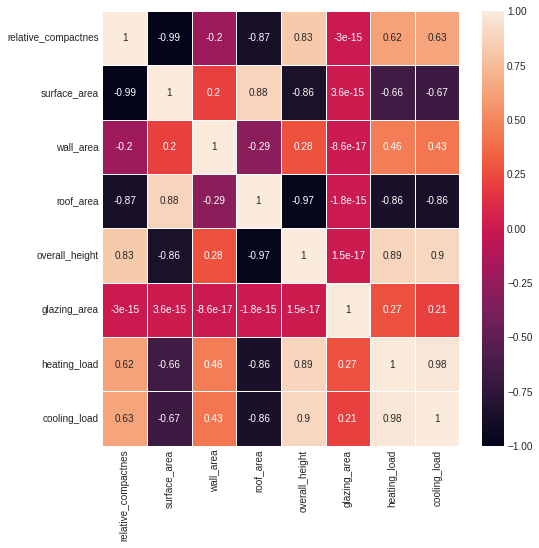

In [12]:
cm = data.corr()
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cm, annot=True, linewidths=.5, vmin=-1, vmax=1)

**Observations:**
* Both target variables ("heating_load" and "cooling_load") have high correlation
* "surface_area" and "relative_compactness" are highly correlated. This is not surprising, since the relative compactness is calculated using the "surcae_area"
* "glazing_area" is not correlated to the other features and has low correlation with the target variables

## Prepare Modelling

This is a multivariate regression problem. In order to prepare the modelling, we will do the following:

* Define features and target variables
* Define train- / validation- and test-sets
* Normalize the data
* One-Hot Encoding for categorical data
* Plot distributions of train- and validation set
* Define the metric used for evaluation

In [13]:
# Define features and target variables (from now on, I will only consider "heating_load" as target)
features = ["relative_compactnes", "surface_area", "wall_area", "roof_area", 
            "overall_height", "orientation", "glazing_area", "glazing_area_distribution"] 
target = "heating_load"

### Train- / Validation- / Test Sets

In [14]:
# trian-/ val-/ test-split
data_train_full, data_test = train_test_split(data[features+[target]], test_size=0.2, random_state=42)
data_train, data_val = train_test_split(data_train_full[features+[target]], test_size=0.25, random_state=42)

In [15]:
# reset indices
data_train_full = data_train_full.reset_index(drop=True)
data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [16]:
# check dataframes
print(f"train full data length {len(data_train_full)}")
print(f"train data length {len(data_train)}")
print(f"val data length {len(data_val)}")
print(f"test data length {len(data_test)}")

train full data length 614
train data length 460
val data length 154
test data length 154


In [17]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactnes        460 non-null    float64
 1   surface_area               460 non-null    float64
 2   wall_area                  460 non-null    float64
 3   roof_area                  460 non-null    float64
 4   overall_height             460 non-null    float64
 5   orientation                460 non-null    string 
 6   glazing_area               460 non-null    float64
 7   glazing_area_distribution  460 non-null    string 
 8   heating_load               460 non-null    float64
dtypes: float64(7), string(2)
memory usage: 32.5 KB


### One-Hot Encoding

In [18]:
# define numerical and categorical features
numerical = ["relative_compactnes", "surface_area", "wall_area", "roof_area", 
            "overall_height", "glazing_area"]
categorical = ["orientation", "glazing_area_distribution"] 

In [19]:
# normalize numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(data_train[numerical])
X_val_num = scaler.transform(data_val[numerical])
print(f"numerical train data shape {X_train_num.shape}")
print(f"numerical val data shape {X_train_num.shape}")

numerical train data shape (460, 6)
numerical val data shape (460, 6)


In [20]:
# one-hot-encoding
train_dicts = data_train[categorical].to_dict(orient="records")
val_dicts = data_val[categorical].to_dict(orient="records")

dv = DictVectorizer(sparse=False) # don't use sparse matrix
dv.fit(train_dicts)
X_train_cat = dv.transform(train_dicts)
X_val_cat = dv.transform(val_dicts)
print(f"categorical train data shape {X_train_cat.shape}")
print(f"categorical val data shape {X_train_cat.shape}")

categorical train data shape (460, 10)
categorical val data shape (460, 10)


In [21]:
# new feature names
dv.get_feature_names()

/home/frauke/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['glazing_area_distribution=0',
 'glazing_area_distribution=1',
 'glazing_area_distribution=2',
 'glazing_area_distribution=3',
 'glazing_area_distribution=4',
 'glazing_area_distribution=5',
 'orientation=2',
 'orientation=3',
 'orientation=4',
 'orientation=5']

In [22]:
# concatenate numerical and categorical features
X_train = np.concatenate((X_train_num, X_train_cat), axis=1)
X_val = np.concatenate((X_val_num, X_val_cat), axis=1)
print(f"train data shape {X_train.shape}")
print(f"val data shape {X_train.shape}")

train data shape (460, 16)
val data shape (460, 16)


### Plot Feature and Target Distributions

Feature distributions of training and validation data

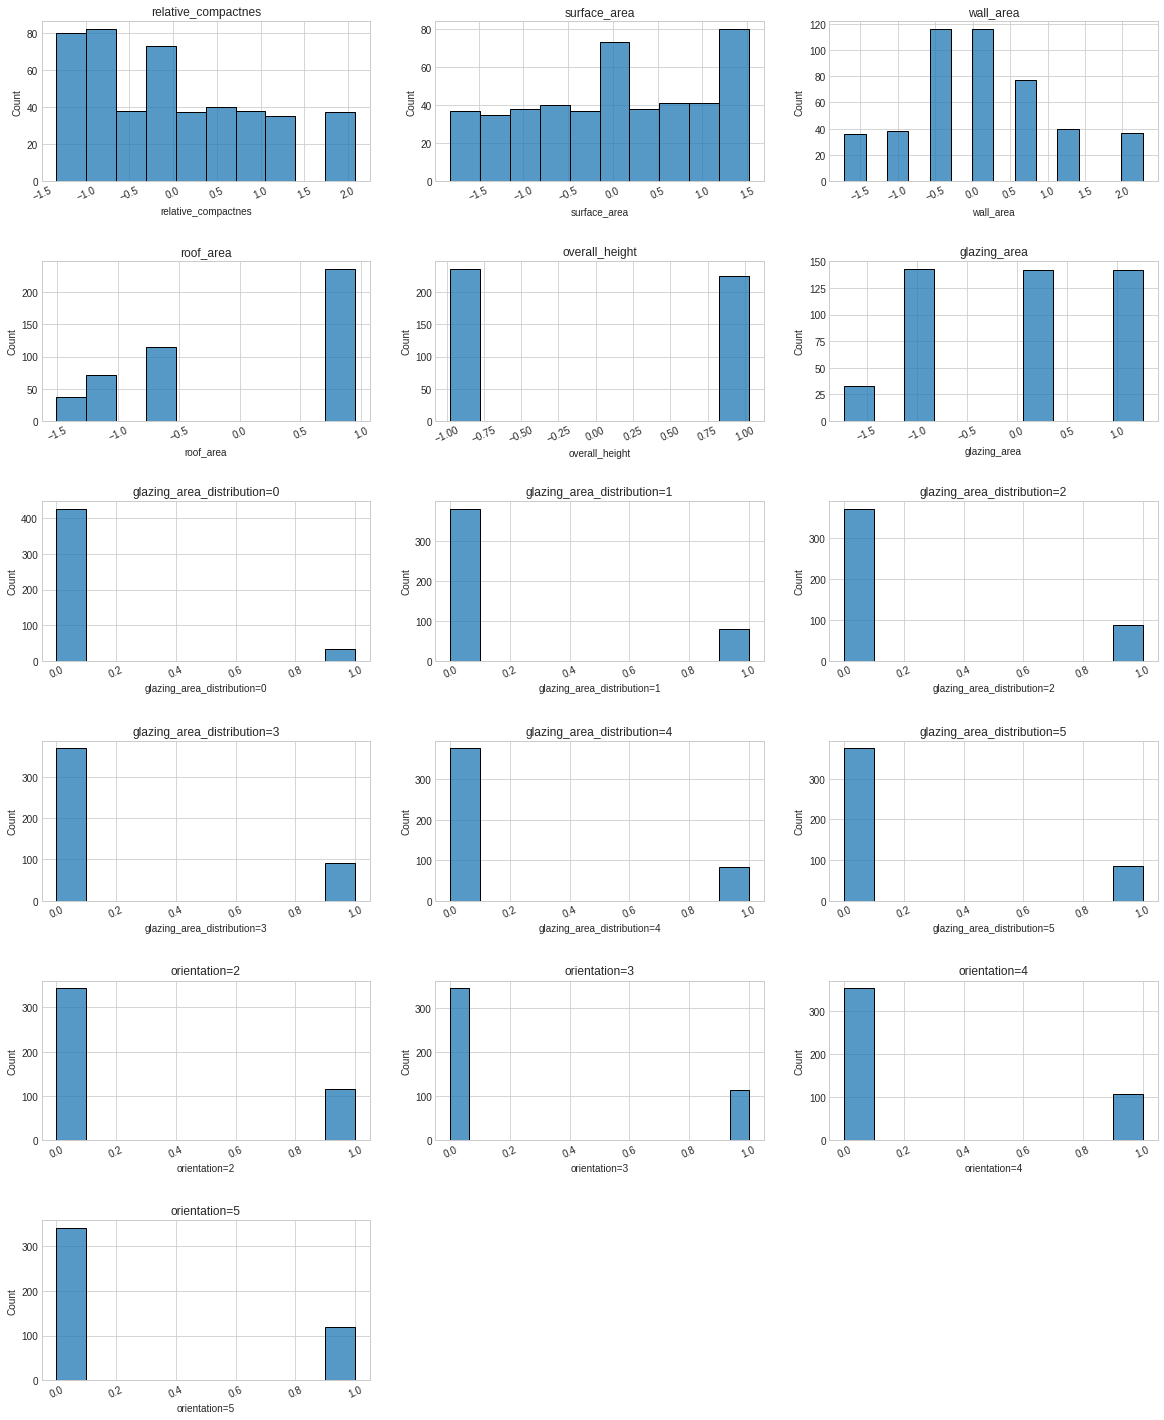

In [23]:
columns = ["relative_compactnes", "surface_area", "wall_area", "roof_area", "overall_height",
           "glazing_area", "glazing_area_distribution=0", "glazing_area_distribution=1", 
           "glazing_area_distribution=2", "glazing_area_distribution=3", "glazing_area_distribution=4",
           "glazing_area_distribution=5", "orientation=2", "orientation=3", "orientation=4", "orientation=5"]
df_train = pd.DataFrame(X_train, columns=columns)
plot_distribution(df_train)

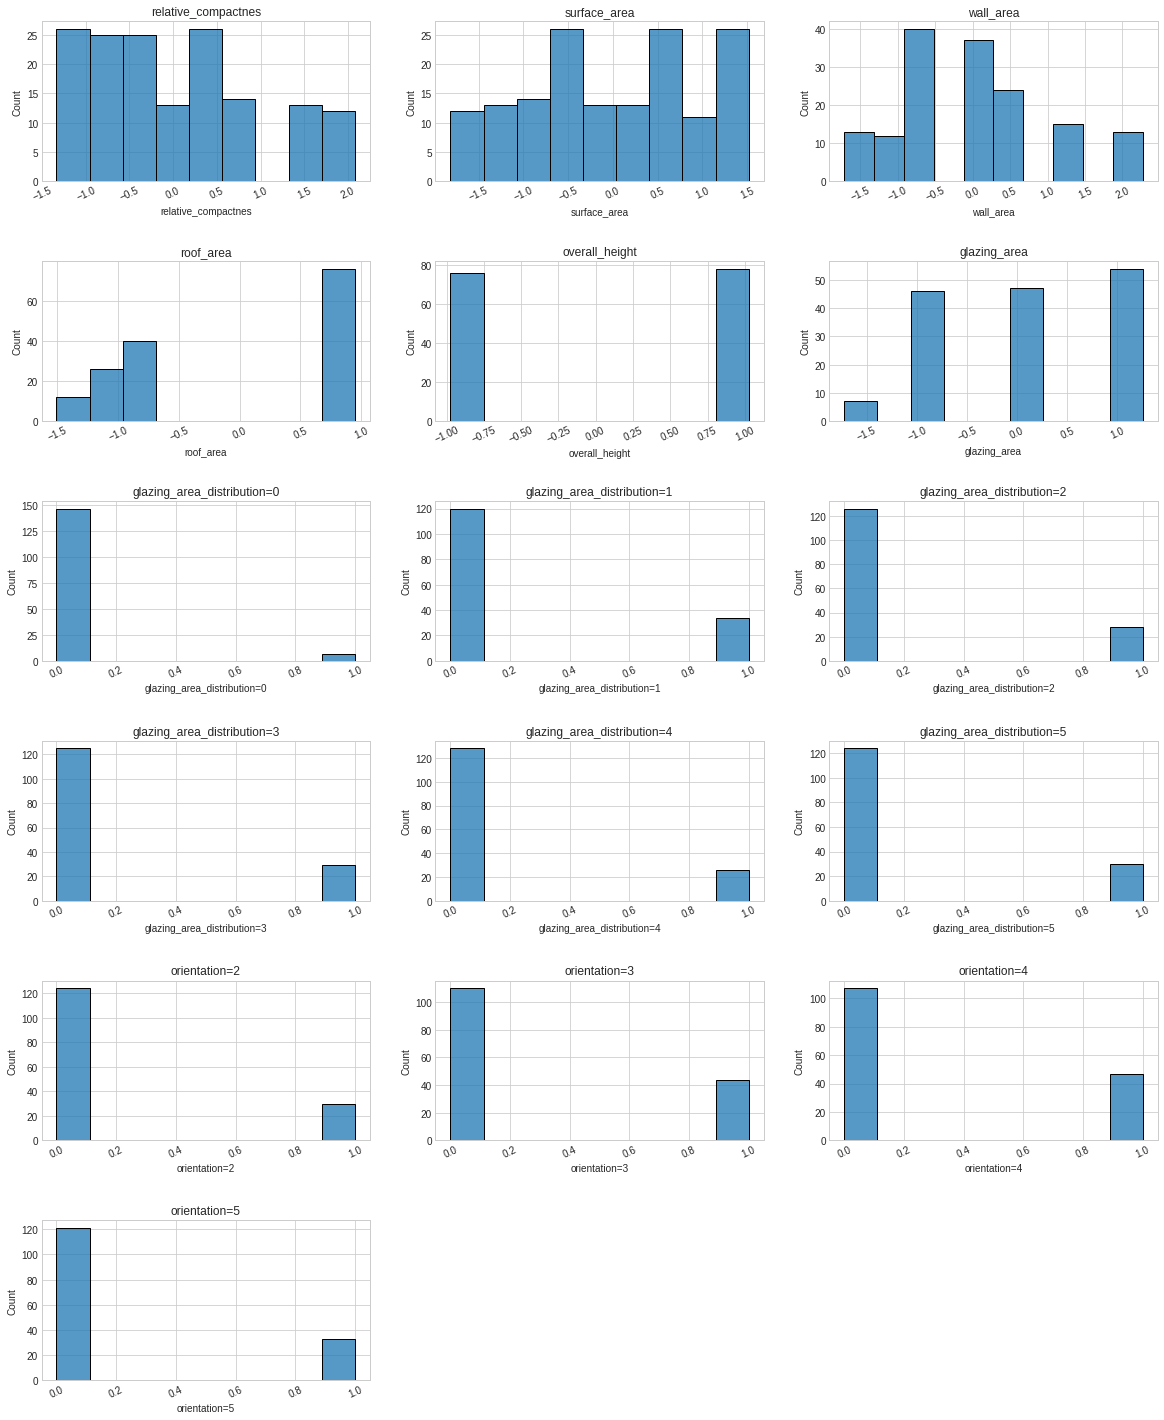

In [24]:
df_val = pd.DataFrame(X_val, columns=columns)
plot_distribution(df_val)

Target data distributions of training and validation set

In [25]:
y_train = data_train[target]
y_val = data_val[target]

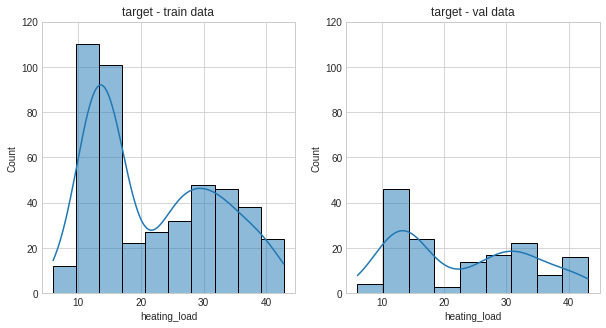

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.histplot(ax=axes[0], x=y_train, kde=True, alpha=0.5)
axes[0].set_title("target - train data")
axes[0].set_ylim(0,120)
sns.histplot( ax=axes[1], x=y_val, kde=True, alpha=0.5)
axes[1].set_title("target - val data")
axes[1].set_ylim(0,120);

### Evaluation Metric

Since we are considering a regresion problem the metric we use for evaluation is the Root Mean Squared Error (RMSE):
    
$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big({y_i -\hat{y}_i}\Big)^2}}$,

with $y_i$ the true target value, $\hat{y}$ the predicted value and $n$ the number of instances.

## Conclusion

With the above steps the dataset is prepared for training. The training (and the needed preparation) are done in a the script ```training.py```.